In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Importing libraries**

In [ ]:
import os #Sindh
import cv2
import math
import random
#import pafy
#import youtube_dl
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from sklearn.model_selection import KFold
from keras.layers import Dense, Dropout, Flatten, TimeDistributed
from keras.layers.convolutional import Conv3D, MaxPooling3D
#from keras.layers.recurrent import LSTM
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv3D, MaxPooling3D, Flatten, LSTM, concatenate
from tensorflow.keras.layers import Reshape

**Note:**

Activation functions used:

* ReLU (Rectified Linear Unit): ReLU is a simple activation function that maps any negative input to 0 and any positive input to itself. Mathematically, it is defined as f(x) = max(0,x). ReLU is commonly used in deep learning because it is easy to compute and has been shown to be effective in preventing the vanishing gradient problem.

* Softmax: Softmax is a activation function that is often used in the output layer of a neural network for multiclass classification problems. It maps the outputs to a probability distribution over the classes. Mathematically, it is defined as f(x_i) = e^(x_i)/sum(e^(x_j)) for i=1,2,...,n where n is the number of classes. The output of the softmax function is a vector of probabilities that sums up to 1.

* Tanh (Hyperbolic tangent): Tanh is a activation function that maps the input to a value between -1 and 1. It is defined as f(x) = (e^x - e^(-x))/(e^x + e^(-x)). Tanh is similar to the sigmoid function, but it is symmetric around the origin and has a steeper gradient near the origin. Tanh is often used in the hidden layers of neural networks.

**Defining Seed**

In [ ]:
seed_constant = 27 #Sindh
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

**Loading Dataset**

In [ ]:
dataset = '/content/drive/MyDrive/CricShot10 dataset (1)' #Sindh(Dataset path change karna pc pai jo ayega)

**Preprocessing Data**

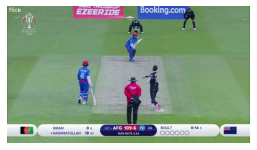

In [ ]:
plt.figure(figsize = (20, 20))  #Sindh
 
#Get the names of all shots/categories in dataset.
all_classes_names = ['cover', 'defense' , 'flick']

 
for classes in all_classes_names:
 
    #selected_class_Name = classes
 
    # Retrieving the list of all the video files present in shot Directories.
    video_files_names_list = os.listdir(f'{dataset}/{classes}')
 
    # Randomly selecting a video file from the list retrieved video files names list.
    selected_video_file_name = random.choice(video_files_names_list)
 
    video_reader = cv2.VideoCapture(f'{dataset}/{classes}/{selected_video_file_name}')
    
    _, bgr_frame = video_reader.read()
 
    video_reader.release()
 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, classes, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, 4);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
# Specifying the height and width to which each video frame will be resized in our dataset.  #Sindh
IMAGE_HEIGHT , IMAGE_WIDTH = 180, 180  

# Specifying the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 10

# Specifying the directory containing the dataset. 
DATASET_DIR = dataset

# Specifying the list containing the names of the classes used for training.
CLASSES_LIST = ['cover', 'defense' , 'flick']


**Extracting frames from videos**

In [ ]:
def frames_extraction(video_path):  #Sindh
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        # Setting the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Checking if Video frame is not successfully read then break the loop
        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalizing the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255.0
        
        frames_list.append(normalized_frame)
    
    video_reader.release()

    return frames_list


**Dataset Creation**

In [ ]:
def create_dataset():  #Sindh
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            
            # Getting the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extracting the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Checking if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    return features, labels, video_files_paths

**Loading Features and Labels**

In [ ]:
features, labels, video_files_paths = create_dataset()  #Sindh

Extracting Data of Class: cover
Extracting Data of Class: defense
Extracting Data of Class: flick


In [ ]:
mean_image = np.mean(features)
print(mean_image)

0.4698756801420168


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)  #Sindh

In [ ]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).   #Sindh
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1, shuffle = True, random_state = seed_constant)

**Making custom LSTM model**

The code defines a function called "create_convlstm_model()" that creates a Convolutional LSTM neural network model. The model has four ConvLSTM2D layers, each followed by a MaxPooling3D layer and a Dropout layer. The output of the last ConvLSTM2D layer is flattened and passed through a Dense layer with a softmax activation function. The model summary is printed and the function returns the model.

In [ ]:
def create_convlstm_model():   
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    model = Sequential()

    # Defining the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    model.summary()
    
    return model

**Model Structure/Shape**

In [ ]:
convlstm_model = create_convlstm_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 10, 178, 178, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 89, 89, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 10, 89, 89, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 10, 87, 87, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 10, 44, 44, 8)    0         
 3D)                                                             
                                                        

In [ ]:
# Ploting the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

** *italicized text*Training the LSTM model**

We will use early stopping because by stopping the training process early, before the model starts to overfit, we can achieve better generalization performance on new data. This is because the model is prevented from becoming too complex and fitting to the noise in the training data.
Also, Cross-Entropy Loss will be used as it measures the difference between the predicted probability and the actual label for each training example. Optimizer "Adam" will be used as it has several advantages over gradient descent, such as fast convergence rates, automatic adaptation to the learning rate, and robustness to noisy gradients and sparse data.


In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
 
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 16,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
7/7 [==============================] - 30s 1s/step - loss: 1.1044 - accuracy: 0.3333 - val_loss: 1.0910 - val_accuracy: 0.4074
Epoch 2/50
7/7 [==============================] - 4s 537ms/step - loss: 1.0939 - accuracy: 0.3148 - val_loss: 1.0977 - val_accuracy: 0.1852
Epoch 3/50
7/7 [==============================] - 4s 526ms/step - loss: 1.0784 - accuracy: 0.3704 - val_loss: 1.0782 - val_accuracy: 0.1852
Epoch 4/50
7/7 [==============================] - 5s 742ms/step - loss: 1.0235 - accuracy: 0.4259 - val_loss: 0.8131 - val_accuracy: 0.7407
Epoch 5/50
7/7 [==============================] - 4s 534ms/step - loss: 0.8889 - accuracy: 0.5741 - val_loss: 0.6875 - val_accuracy: 0.7407
Epoch 6/50
7/7 [==============================] - 4s 549ms/step - loss: 0.8359 - accuracy: 0.5926 - val_loss: 0.6219 - val_accuracy: 0.8148
Epoch 7/50
7/7 [==============================] - 5s 730ms/step - loss: 0.8153 - accuracy: 0.7130 - val_loss: 0.6222 - val_accuracy: 0.7778
Epoch 8/50
7/7 [======

**Model Evaluation**

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)
#print('Test set accuracy:', accuracy)

1/1 [==============================] - 0s 437ms/step - loss: 1.1580 - accuracy: 0.8667


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
# Defining a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
convlstm_model.save(model_file_name)


**Plotting Metrics**

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Constructing a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

**Visualizing the training and validation loss metrices.**

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

**Visualizing the training and validation accuracy metrices.**


In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

**Making custom LRCN model**

The given code creates a function "create_LRCN_model" that returns a Long-term Recurrent Convolutional Networks (LRCN) model for performing action recognition in videos. The model consists of several layers including Conv2D, MaxPooling2D, Dropout, and LSTM layers. The model takes input in the form of sequences of video frames, each of which is processed by the TimeDistributed layer, followed by LSTM and Dense layers for classification.





In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
 
    model = Sequential()
    
    # Defining the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
    ########################################################################################################################
 
    model.summary()
    
    return model

**Construct the required LRCN model.**

In [ ]:
LRCN_model = create_LRCN_model()
 
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 10, 180, 180, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 45, 45, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 10, 45, 45, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 10, 45, 45, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 10, 11, 11, 32)  

**Plotting the structure of the contructed LRCN model.**

In [ ]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

**Training the Model**

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 16 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
7/7 [==============================] - 8s 444ms/step - loss: 1.1413 - accuracy: 0.3796 - val_loss: 1.0781 - val_accuracy: 0.4074
Epoch 2/70
7/7 [==============================] - 1s 91ms/step - loss: 1.0921 - accuracy: 0.3611 - val_loss: 1.0861 - val_accuracy: 0.4074
Epoch 3/70
7/7 [==============================] - 1s 88ms/step - loss: 1.0774 - accuracy: 0.3704 - val_loss: 1.0795 - val_accuracy: 0.5556
Epoch 4/70
7/7 [==============================] - 1s 89ms/step - loss: 1.0454 - accuracy: 0.5278 - val_loss: 1.0297 - val_accuracy: 0.5556
Epoch 5/70
7/7 [==============================] - 1s 88ms/step - loss: 1.0025 - accuracy: 0.5556 - val_loss: 1.0258 - val_accuracy: 0.5926
Epoch 6/70
7/7 [==============================] - 1s 96ms/step - loss: 0.9688 - accuracy: 0.5185 - val_loss: 0.8397 - val_accuracy: 0.7407
Epoch 7/70
7/7 [==============================] - 1s 88ms/step - loss: 0.8649 - accuracy: 0.6389 - val_loss: 0.7668 - val_accuracy: 0.8148
Epoch 8/70
7/7 [==========

**Evaluating the trained model.**


In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)
#print('Test set accuracy:', accuracy)

1/1 [==============================] - 0s 85ms/step - loss: 0.6500 - accuracy: 0.8000


**Getting the loss and accuracy**

In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
LRCN_model.save(model_file_name)

**Visualizing the training and validation loss metrices.**

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

**Visualizing the training and validation accuracy metrices.**

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

The following code is a Python function that performs single action recognition prediction on a video using a LRCN model. It takes the path of the video file and a fixed number of frames as input. The function first reads the video file and extracts frames from it, resizes them, and normalizes them by dividing their values by 255. These preprocessed frames are then passed to the LRCN model to get the predicted probabilities for each action. The function selects the action with the highest probability and prints its name along with the confidence. Finally, the function releases the video reader object.

In [ ]:
def predict_single_action_LRCN(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
 
    video_reader = cv2.VideoCapture(video_file_path)
 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    frames_list = []
    
    predicted_class_name = ''
 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    for frame_counter in range(SEQUENCE_LENGTH):
 
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 
 
        # Check if frame is not read properly then break the loop.
        if not success:
            break
 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    video_reader.release()

**Input video file paths**

In [ ]:
input_video_path = '/content/drive/MyDrive/cover video.avi'
input_video_path_2 = '/content/drive/MyDrive/defense video.avi'
input_video_path_3 = '/content/drive/MyDrive/flick video.avi'

**Perform Single Prediction on the Test Videos**

In [ ]:
predict_single_action_LRCN(input_video_path, SEQUENCE_LENGTH)
predict_single_action_LRCN(input_video_path_2, SEQUENCE_LENGTH)
predict_single_action_LRCN(input_video_path_3, SEQUENCE_LENGTH)

The following code defines a function that creates a 3D convolutional neural network model for action recognition. The model takes as input a sequence of images, with a fixed length, and has several convolutional and max pooling layers. The output of the convolutional layers is flattened and passed through a dense layer with a softmax activation function, which predicts the probability of each action class. The model is returned by the function.

In [ ]:
def create_3D_CNN():   #Sindh
  '''
    This function will construct the required 3DCNN model.
    Returns:
        model: It is the required constructed 3DCNN model.
  '''

  # Defining the Model Architecture.
    ########################################################################################################################

  input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

  inputs = Input(shape=input_shape)

  x = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(inputs)
  
  x = MaxPooling3D(pool_size=(2, 2, 2))(x)
  
  x = (TimeDistributed(Dropout(0.2)))(x)
  
  x = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(x)
  
  x = MaxPooling3D(pool_size=(2, 2, 2))(x)

  x = Flatten()(x)

  outputs = Dense(units=len(CLASSES_LIST), activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  ########################################################################################################################

  model.summary()

  return model

**Construct the required 3D CNN model**

In [ ]:
CNN3D_model = create_3D_CNN()   #Sindh
print("Model Created Successfully!")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 180, 180, 3)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 8, 178, 178, 32)   2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 89, 89, 32)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 4, 89, 89, 32)    0         
 ibuted)                                                         
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 87, 87, 64)     55360     
                                                             

**Plotting the structure of the contructed 3D CNN model**

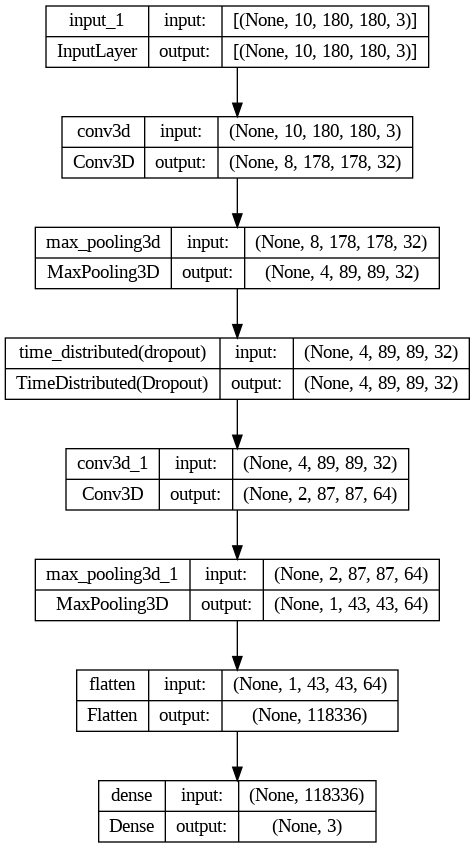

In [ ]:
plot_model(CNN3D_model, to_file = 'CNN3D_model_structure_plot.png', show_shapes = True, show_layer_names = True)   #Sindh

**Start training the model**

In [ ]:
CNN3D_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   #Sindh

In [ ]:
# Define the number of folds for cross-validation
k = 5            #Sindh

# Load your 3D data here
X = features_train
y = labels_train

# Define the K-fold cross-validator
kf = KFold(n_splits=k)

In [ ]:
# Iterate over each fold                  #Sindh
for i, (train_index, val_index) in enumerate(kf.split(X)):
    
    print(f'Fold {i+1}/{k}')
    
    # Split the data into training and validation sets for this fold
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Fit the model on the training set for this fold
    CNN3D_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
    
    # Evaluate the model on the validation set for this fold
    scores = CNN3D_model.evaluate(X_val, y_val, verbose=0)
    print(f'Validation accuracy: {scores[1]}')

Fold 1/5
Epoch 1/10
4/4 [==============================] - 16s 881ms/step - loss: 5.7591 - accuracy: 0.3611 - val_loss: 1.3949 - val_accuracy: 0.2963
Epoch 2/10
4/4 [==============================] - 1s 351ms/step - loss: 1.6686 - accuracy: 0.4074 - val_loss: 1.0923 - val_accuracy: 0.5185
Epoch 3/10
4/4 [==============================] - 2s 409ms/step - loss: 1.0781 - accuracy: 0.4907 - val_loss: 1.0604 - val_accuracy: 0.6667
Epoch 4/10
4/4 [==============================] - 2s 430ms/step - loss: 1.0294 - accuracy: 0.5370 - val_loss: 1.0070 - val_accuracy: 0.6667
Epoch 5/10
4/4 [==============================] - 1s 332ms/step - loss: 1.0022 - accuracy: 0.6111 - val_loss: 1.0077 - val_accuracy: 0.5926
Epoch 6/10
4/4 [==============================] - 1s 332ms/step - loss: 0.9597 - accuracy: 0.5370 - val_loss: 0.9492 - val_accuracy: 0.7037
Epoch 7/10
4/4 [==============================] - 1s 378ms/step - loss: 0.8450 - accuracy: 0.7037 - val_loss: 0.8252 - val_accuracy: 0.6296
Epoch 8/10

In [ ]:
model_evaluation_history = CNN3D_model.evaluate(features_test, labels_test)
#print('Test set accuracy:', accuracy)

1/1 [==============================] - 0s 444ms/step - loss: 0.7727 - accuracy: 0.8000


In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
CNN3D_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
CNN3D_model_training_history = CNN3D_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 32 , shuffle = True, validation_split = 0.1, callbacks = [early_stopping_callback])

**Evaluating the trained model**

**Visualizing the training and validation loss metrices.**

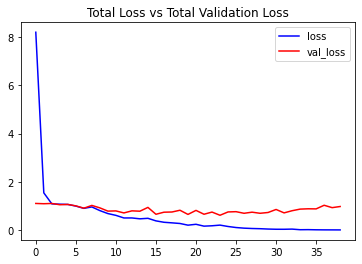

In [ ]:
plot_metric(CNN3D_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

**Visualizing the training and validation accuracy metrices.**

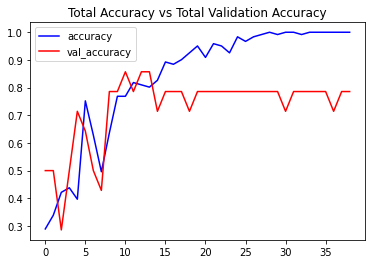

In [ ]:
plot_metric(CNN3D_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

The following code defines a function called "predict_single_action_CNN3D", which predicts a single action recognition for a given video file using a pre-trained CNN3D model. The function first initializes a VideoCapture object to read the frames from the video file. It then extracts a fixed number of frames (SEQUENCE_LENGTH) from the video with a fixed skip interval, and preprocesses each frame by resizing and normalizing it. The preprocessed frames are then passed to the pre-trained CNN3D model to obtain predicted probabilities. The function prints the predicted action and its confidence score, and releases the VideoCapture object.

In [ ]:
def predict_single_action_CNN3D(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the 3D CNN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
 
    video_reader = cv2.VideoCapture(video_file_path)
 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    frames_list = []
    
    predicted_class_name = ''
 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    for frame_counter in range(SEQUENCE_LENGTH):
 
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 
 
        # Check if frame is not read properly then break the loop.
        if not success:
            break
 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = CNN3D_model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    video_reader.release()

**Input video paths**

In [ ]:
input_video_path = '/content/drive/MyDrive/Val data/Video 1.avi'  #cover
input_video_path_2 = '/content/drive/MyDrive/Val data/Video 3.avi'  #defence
input_video_path_3 = '/content/drive/MyDrive/Val data/Video 6.avi'  #flick
input_video_path_4 = '/content/drive/MyDrive/Val data/Video 2.avi'  #cover
input_video_path_5 = '/content/drive/MyDrive/Val data/Video 5.avi'  #flick
input_video_path_6 = '/content/drive/MyDrive/Val data/Video 4.avi'  #defence

**Perform Single Prediction on the Test Videos**


In [ ]:
predict_single_action_CNN3D(input_video_path, SEQUENCE_LENGTH)
predict_single_action_CNN3D(input_video_path_2, SEQUENCE_LENGTH)
predict_single_action_CNN3D(input_video_path_3, SEQUENCE_LENGTH)
predict_single_action_CNN3D(input_video_path_4, SEQUENCE_LENGTH)
predict_single_action_CNN3D(input_video_path_5, SEQUENCE_LENGTH)
predict_single_action_CNN3D(input_video_path_6, SEQUENCE_LENGTH)

1/1 [==============================] - 0s 184ms/step
Action Predicted: cover
Confidence: 0.9370123744010925
1/1 [==============================] - 0s 27ms/step
Action Predicted: defense
Confidence: 0.9960243701934814
1/1 [==============================] - 0s 32ms/step
Action Predicted: cover
Confidence: 0.9910007119178772
1/1 [==============================] - 0s 20ms/step
Action Predicted: cover
Confidence: 0.8843838572502136
1/1 [==============================] - 0s 22ms/step
Action Predicted: flick
Confidence: 0.8990086913108826
1/1 [==============================] - 0s 21ms/step
Action Predicted: defense
Confidence: 0.9987768530845642


In [ ]:
# Load the pre-trained 3D CNN model                   #Sindh
#model = load_model('my_3dcnn_model.h5')

# Define the input shape of the model
input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)   # 16 frames of size 112x112 with 3 color channels (RGB)

# Open a video capture device for real-time video input
cap = cv2.VideoCapture(0)

# Define a loop to read frames from the video stream and classify them
while True:
    # Read a frame from the video stream
    ret, frame = cap.read()
    if not ret:
        break

    # Resize the frame to the input shape of the model
    frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    frame = np.expand_dims(frame, axis=0)  # Add batch dimension
    frame = np.repeat(frame, input_shape[0], axis=0)  # Repeat the frame to fill the input shape

    # Predict the class probabilities for the input frames
    probabilities = CNN3D_model.predict(frame)

    # Get the predicted class label
    predicted_class = np.argmax(probabilities)

    # Display the predicted class label on the frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2
    text = 'Class: {}'.format(predicted_class)
    text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
    text_x = 10
    text_y = 10 + text_size[1]
    cv2.putText(frame, text, (text_x, text_y), font, font_scale, (0, 255, 0), thickness)

    # Display the frame
    cv2.imshow('Real-time video classification', frame)

    # Wait for a key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture device and close the display window
cap.release()
cv2.destroyAllWindows()
